# Estimation of IMC signal decay on fixed HEK cells on ibidi glass slide

Tasks:
- Include nuclei segmentation to improve the estimation (dark pixel may lead to underestimation of IMC signal)
- Refer to IMC analysis workflow to see if they use any python package to remove hot pixels

In [145]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage
from cellpose import models
from readimc import MCDFile, TXTFile

In [146]:
work_dir = os.getcwd()
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/Imager_rehybridization_imc"

# list out all the files in the directory
mcd_list = os.listdir(data_dir)
mcd_list = [f for f in mcd_list if f.endswith('.mcd')]

df_list = os.listdir(data_dir)
df_list = [f for f in df_list if f.endswith('.xlsx')]

print(mcd_list)
print(df_list)


['20250422_QH_eGFP_RCA_in_vivo_IMC.mcd']
['20250422_QH_eGFP_RCA_in_vivo_IMC_df.xlsx']


In [147]:
tif_dir = os.path.join(data_dir, 'tif')
if not os.path.exists(tif_dir):
    os.makedirs(tif_dir)

In [148]:
df = pd.read_excel(os.path.join(data_dir, df_list[0]))
# set the data type of the columns
df = df.astype({'file_name': 'str', 'image_decay': 'str', 'resolution': 'float', 'power': 'int', 'shot': 'int', 'rep': 'int', 'id': 'str', 'cond': 'str'})

In [149]:
df.head(70)

,file_name,image_decay,resolution,power,shot,rep,id,cond
0,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_001_1,image,1.00,0,1,1,1,GFP
1,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_002_2,image,1.00,0,1,1,2,WT
2,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_003_3,image,0.33,-10,1,1,3,GFP
3,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_004_4,image,0.33,-10,1,1,4,WT
4,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_005_5,image,0.33,-10,1,2,5,GFP
5,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_006_6,image,0.33,-10,1,3,6,GFP
6,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_007_7,image,0.50,-5,1,1,7,GFP
7,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_008_8,image,0.50,-5,1,2,8,GFP
8,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_009_9,image,0.50,-5,1,3,9,GFP
9,20250422_QH_eGFP_RCA_in_vivo_IMC_ROI_010_10,image,0.50,-5,1,1,10,WT


Set up the decay image groups

In [150]:
# set up the decay group
# store numerical list in the dictionary
decay_dict = {'-10db': list(range(13,23)), '-5db': list(range(23,28))}
print(decay_dict)

{'-10db': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22], '-5db': [23, 24, 25, 26, 27]}


## Read in files

In [151]:
def read_imc_dict(file_big, id):
    #return a dictionary with three images: slide, panorama, imc
    with MCDFile(file_big) as f:
        slide = f.slides[0] # first slide
        panorama = slide.panoramas[0] # first panorama of first slide
        acquisition = slide.acquisitions[id-1]
        
        channel_labels = acquisition.channel_labels
        
        img_slide = f.read_slide(slide)
        img_panorama = f.read_panorama(panorama)
        img_imc = f.read_acquisition(acquisition)

        # put the image into a dictionary
        img_dict = {}
        img_dict['slide'] = img_slide
        img_dict['panorama'] = img_panorama
        img_dict['description'] = acquisition.description
        img_dict['imc'] = img_imc
    return img_dict, channel_labels

def convert_imc_to_tif(file_big, id, output_dir):
    with MCDFile(file_big) as f:
        slide = f.slides[0] # first slide
        acquisition = slide.acquisitions[id-1] # nineth acquisition of first slide
        
        channel_labels = acquisition.channel_labels
        img_imc = f.read_acquisition(acquisition)
        # save the image as tif [channel, x, y]
        file_name = os.path.join(tif_dir, acquisition.description + ".tif")
        tiff.imwrite(file_name, img_imc)
    return

In [152]:
file_big =  mcd_list[0]
file_big = os.path.join(data_dir, file_big)
file_big

'/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250417_eGFP_re_in_vivo_RCA/Imager_rehybridization_imc/20250422_QH_eGFP_RCA_in_vivo_IMC.mcd'

### Convert all image mcds to tiffs (standalone block)

In [22]:
for id in df['id'].unique():
    # convert the imc to tif
    id = int(id)
    print("Converting id: ", id)
    convert_imc_to_tif(file_big, id, tif_dir)

Converting id:  1
Converting id:  2
Converting id:  3
Converting id:  4
Converting id:  5
Converting id:  6
Converting id:  7
Converting id:  8
Converting id:  9
Converting id:  10
Converting id:  11
Converting id:  12
Converting id:  13
Converting id:  14
Converting id:  15
Converting id:  16
Converting id:  17
Converting id:  18
Converting id:  19
Converting id:  20
Converting id:  21
Converting id:  22
Converting id:  23
Converting id:  24
Converting id:  25
Converting id:  26
Converting id:  27


## Image-level quantification

To estimate the decay over multiple shot, quantify mean and median of each 100x100 image

In [153]:
def plot_imc_nuc(img_imc, imc_dict, chn_idx, colim, output_subdir):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
    plt.subplot(1, 2, 1)
    # set subplot size
    plt.imshow(img_imc[chn_idx, :, :], cmap='gray')
    plt.axis('on')
    # set the colorbar
    plt.colorbar(fraction=0.0458, pad=0.04)
    # set dynamic range 
    plt.clim(0, colim)
    # add subtitle
    plt.title('193Ir')   
    
    plt.subplot(1, 2, 2)
    # plot the histogram of intensity
    plt.hist(img_imc[chn_idx, :, :].flatten(), bins=50, range=(0, colim))
    plt.ylim(0, 10000)
    # add x and y labels
    plt.xlabel('Intensity')
    plt.ylabel('Counts')
    plt.title('Intensity distribution')
    
    # add the plot title
    plt.suptitle(imc_dict['description'])
    
    # save the plot
    plt.savefig(os.path.join(output_subdir, imc_dict['description'] + ".png"))
    plt.show()

In [154]:
power = '-10db'

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


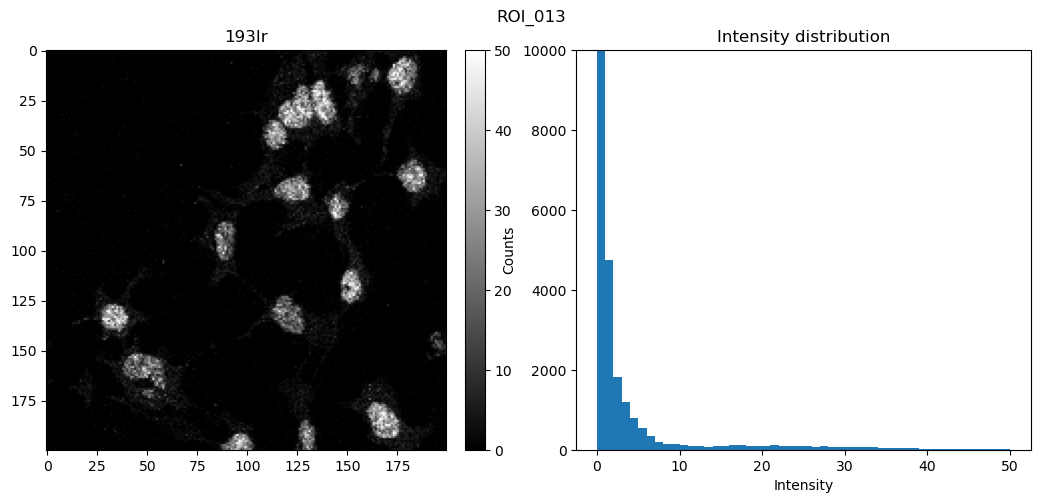

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


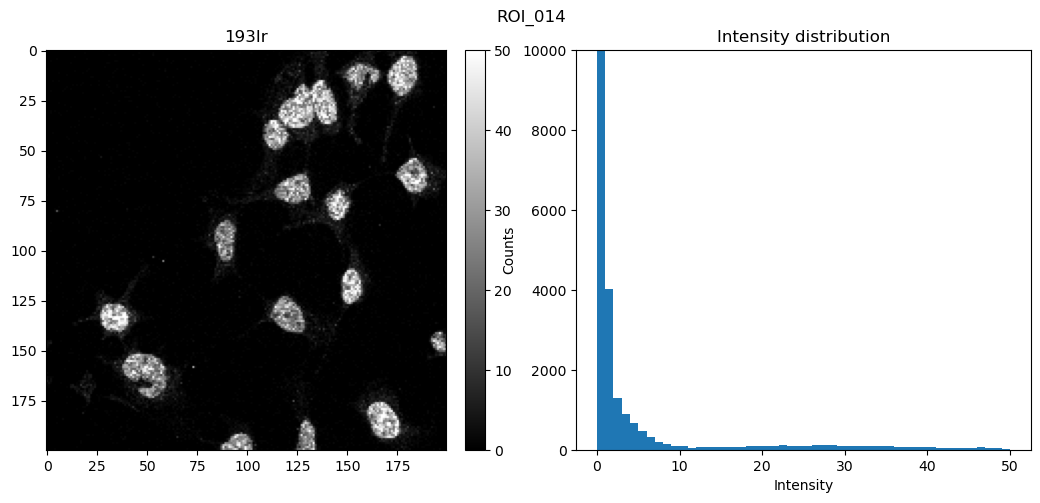

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


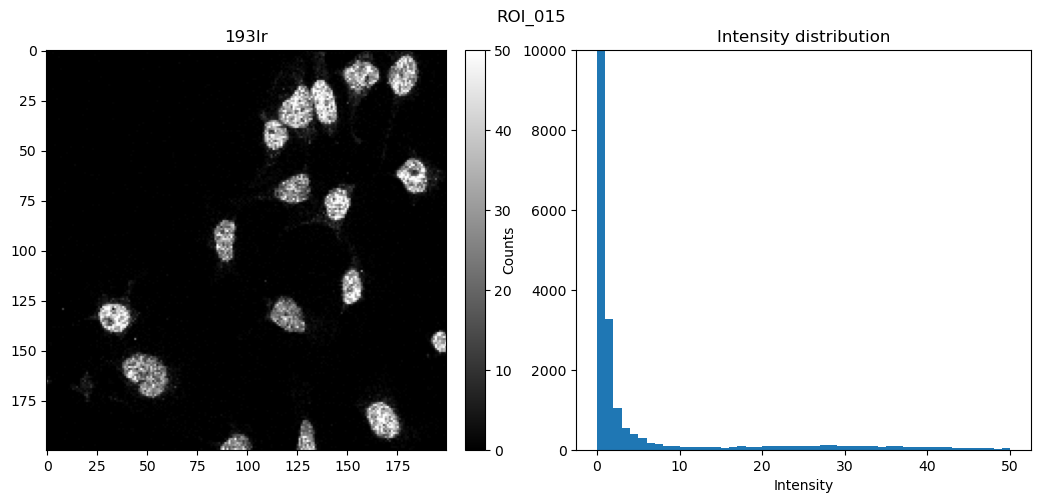

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


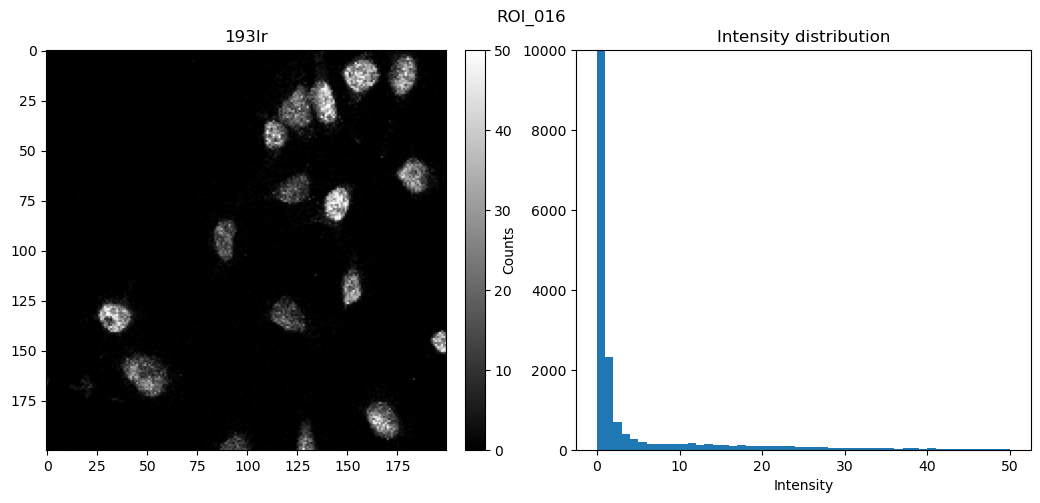

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


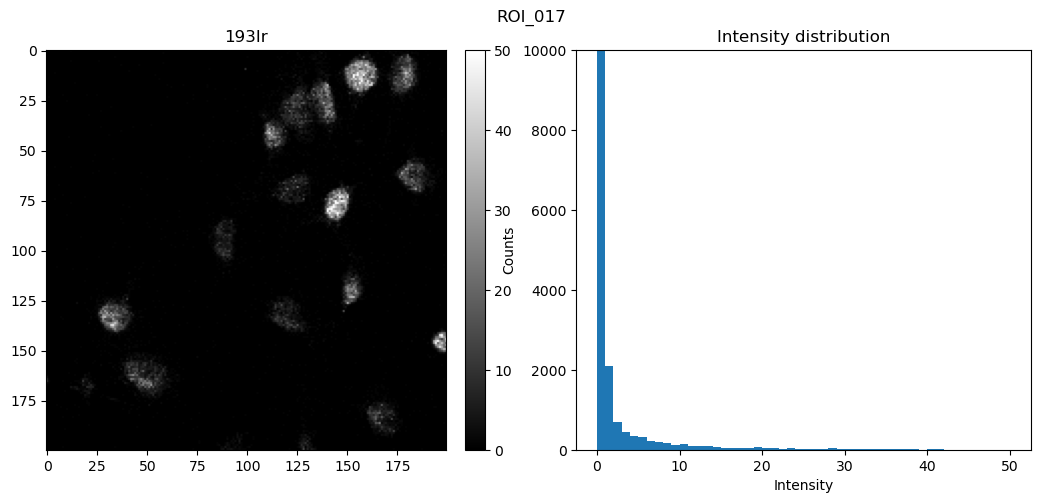

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


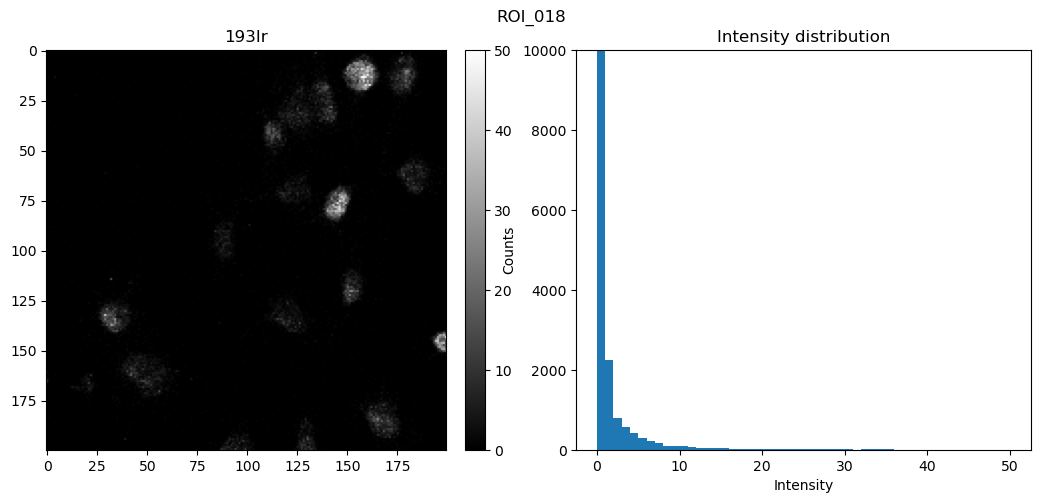

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


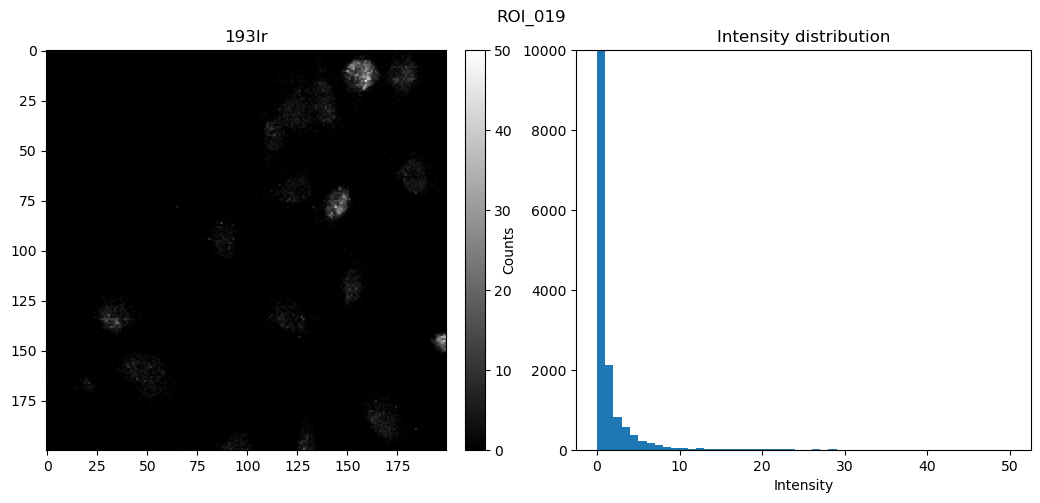

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


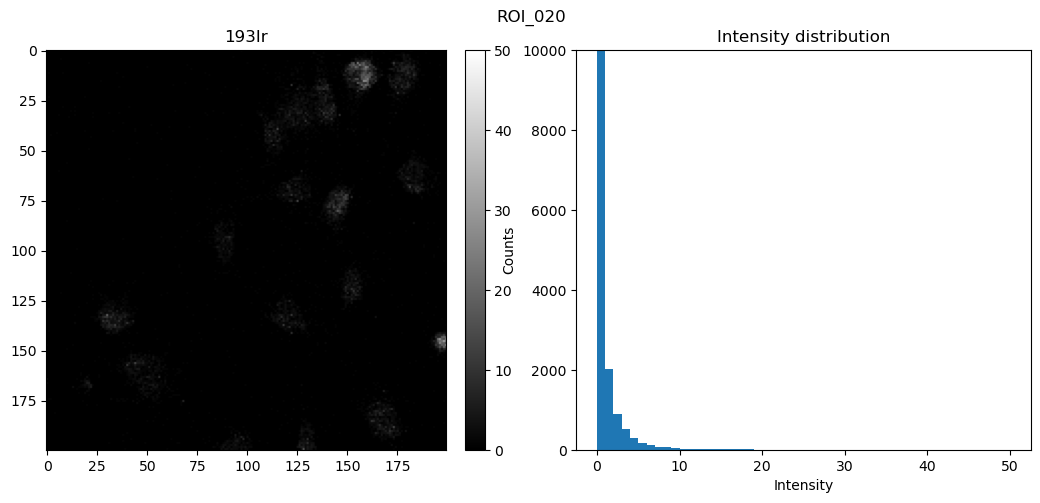

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


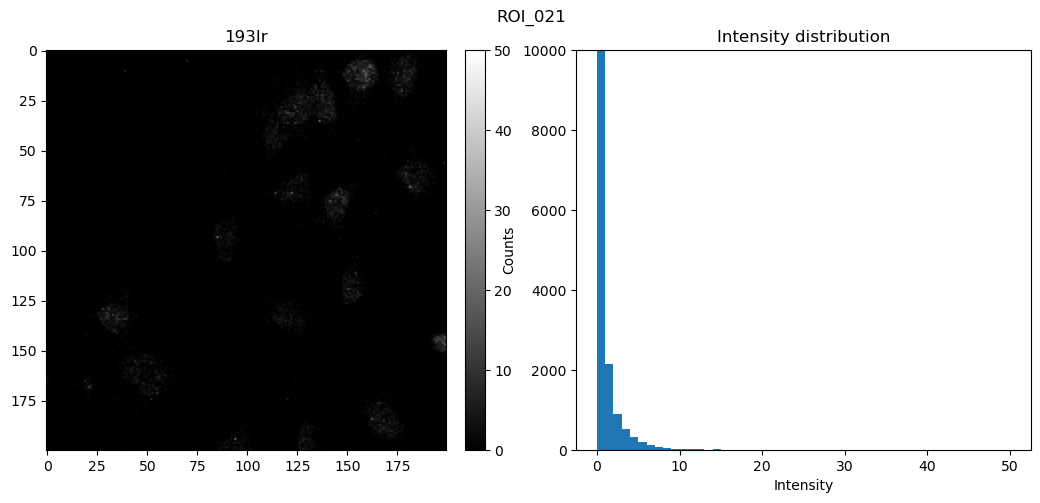

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


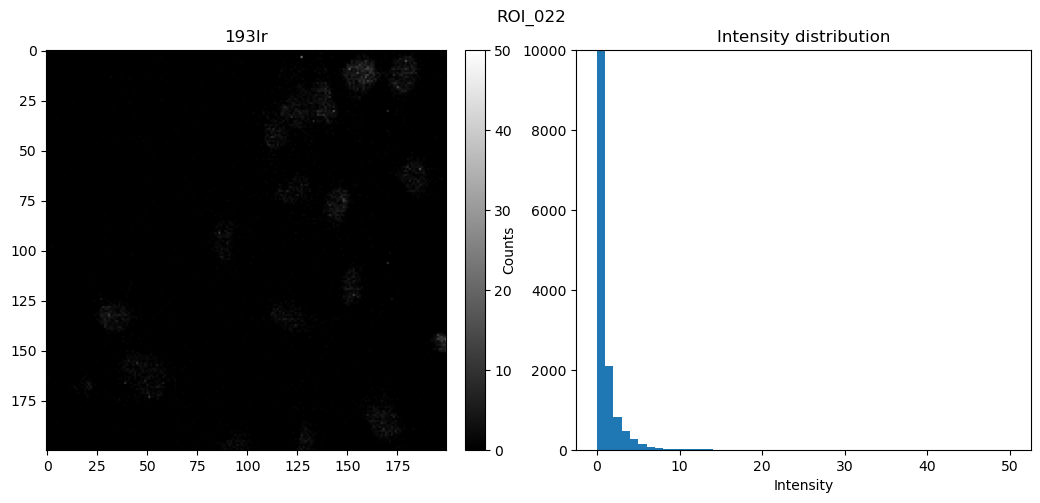

In [155]:
# create a new folder for saving the images
decay_dir = os.path.join(data_dir, power+"_decay_193Ir")
if not os.path.exists(decay_dir):
    os.makedirs(decay_dir)

# data frame
imc_193Ir_stats = pd.DataFrame(columns=['shot', 'id', 'mean', 'median', 'std', 'min', 'max'])

# read image id from n to n+10, plot the images
for id in decay_dict[power]:
    shot = df.loc[df['id'] == str(id)]['shot'].values[0]
    imc_dict, channel_labels = read_imc_dict(file_big, id)
    img_imc = imc_dict['imc']
    
    # find the channel label
    chn_idx = channel_labels.index('193Ir_193Ir')
    
    plot_imc_nuc(img_imc, imc_dict, chn_idx, 50, decay_dir)
    
    # get statistics of the image with the channel label
    img_imc_193Ir = img_imc[chn_idx, :, :]
    mean = np.mean(img_imc_193Ir)
    median = np.median(img_imc_193Ir)
    std = np.std(img_imc_193Ir)
    min = np.min(img_imc_193Ir)
    max = np.max(img_imc_193Ir)
    
    # add the statistics to the data frame
    imc_193Ir_stats.loc[len(imc_193Ir_stats)] = [shot, id, mean, median, std, min, max]
    

In [156]:
imc_193Ir_stats

,shot,id,mean,median,std,min,max
0,1.0,13.0,2.233494,0.0,6.743950,0.0,70.00
1,2.0,14.0,2.904037,0.0,8.791030,0.0,80.50
2,3.0,15.0,2.823606,0.0,9.044284,0.0,89.25
3,4.0,16.0,1.764144,0.0,6.314609,0.0,69.50
4,5.0,17.0,0.932731,0.0,3.945854,0.0,67.75
5,6.0,18.0,0.619812,0.0,2.789431,0.0,57.50
6,7.0,19.0,0.410313,0.0,1.898666,0.0,56.25
7,8.0,20.0,0.294713,0.0,1.302428,0.0,32.00
8,9.0,21.0,0.269475,0.0,1.073268,0.0,21.50
9,10.0,22.0,0.213431,0.0,0.874688,0.0,25.25


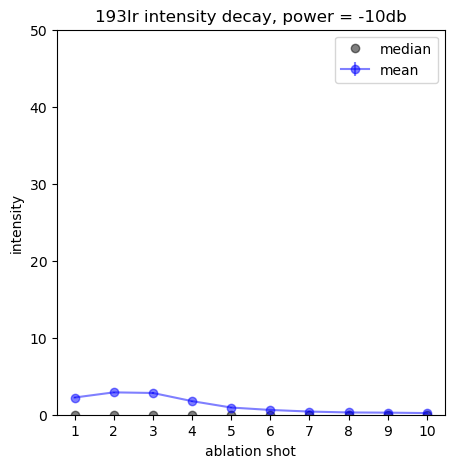

In [157]:
plt.figure(figsize=(5, 5))
plt.errorbar(imc_193Ir_stats['shot'], imc_193Ir_stats['mean'], yerr=imc_193Ir_stats['std']/100, fmt='bo-', alpha = 0.5, label='mean')
# plot the median
plt.plot(imc_193Ir_stats['shot'], imc_193Ir_stats['median'], 'ko', alpha = 0.5, label='median')
plt.legend()

plt.xticks(imc_193Ir_stats['shot'])
plt.xlabel('ablation shot')
plt.ylabel('intensity')
plt.ylim(0, 50)
# set title
plt.title('193Ir intensity decay, power = ' + power)
# save 
plt.savefig(os.path.join(decay_dir, '193Ir_intensity_decay_' + power + '.png'))
plt.show()

## Image-level quantification, with nuclei-segmentation

To estimate the decay over multiple shot, quantify mean and median of each 100x100 image

In [158]:
power = '-10db'

In [159]:
decay_dir = os.path.join(data_dir, power+"_decay_193Ir_seg")
if not os.path.exists(decay_dir):
    os.makedirs(decay_dir)

# sum of all image (for segmentation)
img_nuc_sum = np.zeros((200, 200))

sum over all decay images to get a "sum" image for segmentation.

In [160]:
decay_dict[power]

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [161]:
# read image id from n to n+10, plot the images
for id in decay_dict[power]:
    imc_dict, channel_labels = read_imc_dict(file_big, id)
    img_imc = imc_dict['imc']
    
    # find the channel label
    chn_idx = channel_labels.index('193Ir_193Ir')
    
    # plot_imc_nuc(img_imc, imc_dict, chn_idx, 50, output_subdir)

    img_imc_193Ir = img_imc[chn_idx, :, :]
    img_nuc_sum = img_nuc_sum + img_imc_193Ir
    

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Ready for segmentation

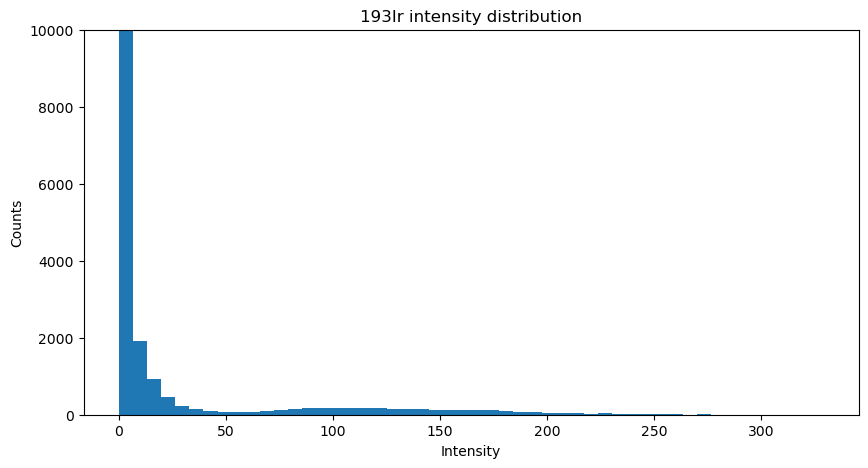

In [162]:
# plot histogram showing the intensity distribution of the sum of all images
plt.figure(figsize=(10, 5))
# histogram of the sum of all images
plt.hist(img_nuc_sum.flatten(), bins=50, range=(0, np.max(img_nuc_sum)))
plt.ylim(0, 10000)
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title('193Ir intensity distribution')
plt.show()

In [163]:
# remove outlier pixel, push all the pixel value larger than specified value to the specified value
def remove_outlier(img, value):
    img[img > value] = value
    return img

# remove the outlier pixel
img_nuc_sum = remove_outlier(img_nuc_sum, 200)

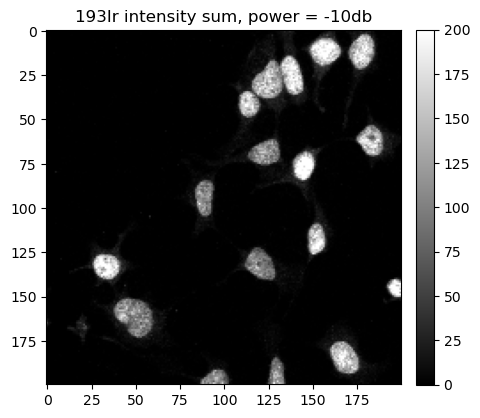

In [164]:
# plot img_sum_nuc and img_sum_mem
plt.figure(figsize=(5, 5))
plt.imshow(img_nuc_sum, cmap='gray')
plt.axis('on')
plt.colorbar(fraction=0.0458, pad=0.04)
plt.clim(0, np.max(img_nuc_sum))
plt.title('193Ir intensity sum, power = ' + power)
plt.show()


### Cellpose segmentation

Load packages and models

In [165]:
model = models.Cellpose(model_type="nuclei")

In [166]:
channels = [[0, 0]]

masks, flows, styles, diams = model.eval(img_nuc_sum, diameter=None, channels = channels)

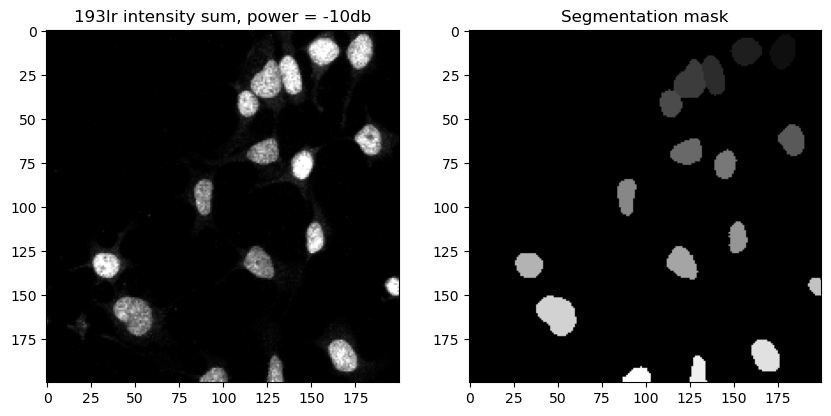

In [167]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_nuc_sum, cmap='gray')
plt.title('193Ir intensity sum, power = ' + power)

plt.subplot(1, 2, 2)
plt.imshow(masks, cmap='gray')
plt.title('Segmentation mask')

plt.show()

Convert the nuc segmentation result into binary mask

In [168]:
nuc_bmask = masks > 0
nuc_bmask = nuc_bmask.astype(np.bool)

### Masked pixel-level decay estimation

In [169]:
def plot_imc_nuc_with_overlays(img_imc, imc_dict, chn_idx, colim, decay_dir, nuc_mask):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
    plt.subplot(1, 2, 1)
    plt.imshow(img_imc[chn_idx, :, :] + 5*nuc_mask, cmap='gray')
    plt.axis('on')
    # set the colorbar
    plt.colorbar(fraction=0.0458, pad=0.04)
    # set dynamic range 
    plt.clim(0, colim)
    # add subtitle
    plt.title('193Ir')   
    
    plt.subplot(1, 2, 2)
    # plot the histogram of intensity
    plt.hist(img_imc[chn_idx, :, :][nuc_mask == 1].flatten(), bins=50, range=(0, colim))
    plt.ylim(0, 10000)
    # add x and y labels
    plt.xlabel('Intensity')
    plt.ylabel('Counts')
    plt.title('Intensity distribution')
    
    # add the plot title
    plt.suptitle(imc_dict['description'])
    
    # save the plot
    plt.savefig(os.path.join(decay_dir, imc_dict['description'] + ".png"))
    plt.show()

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


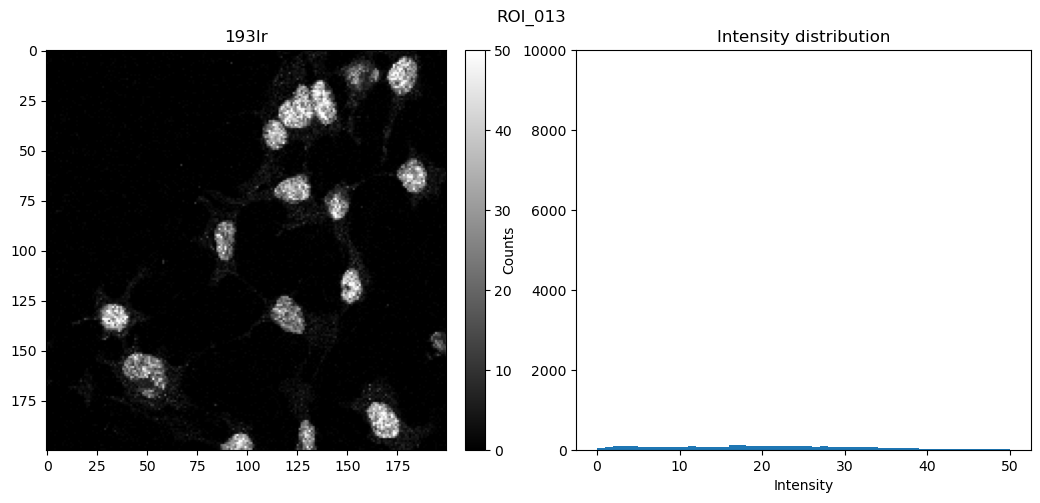

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


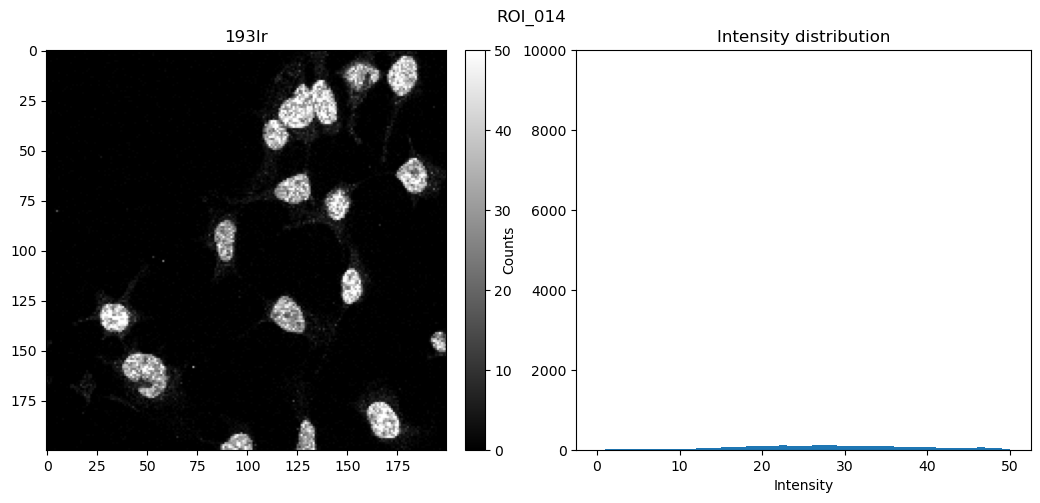

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


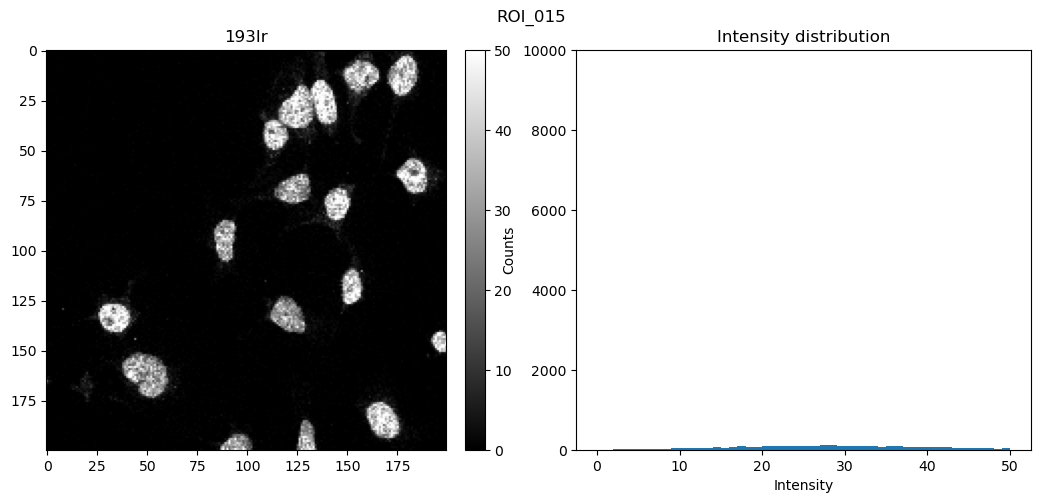

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


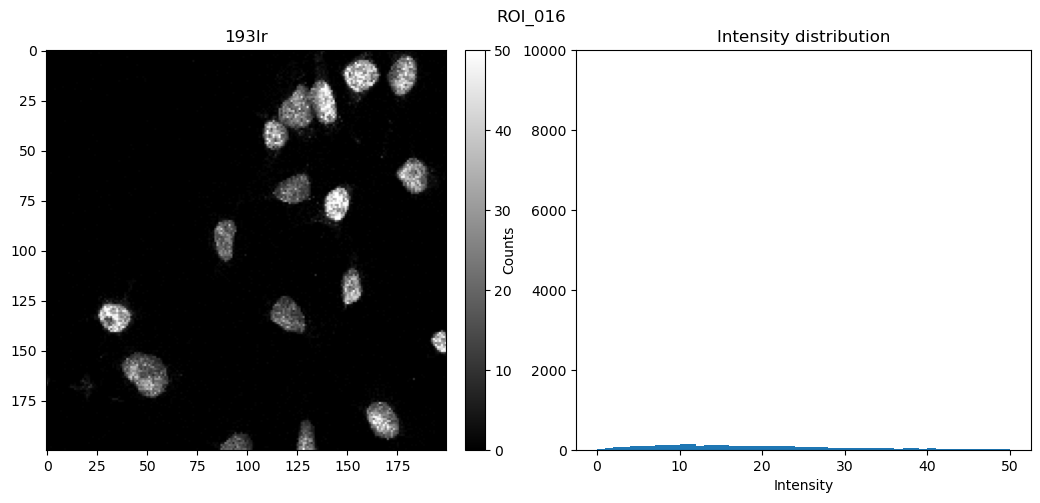

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


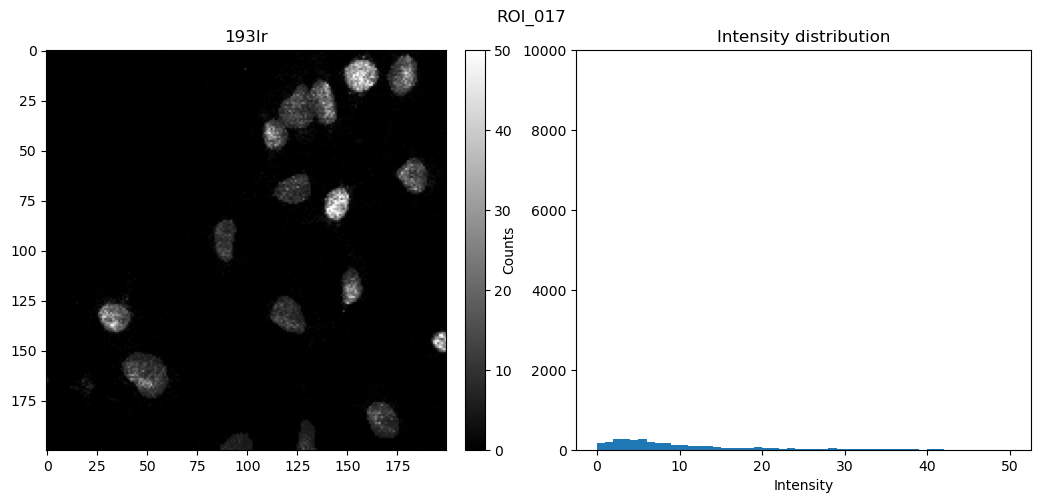

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


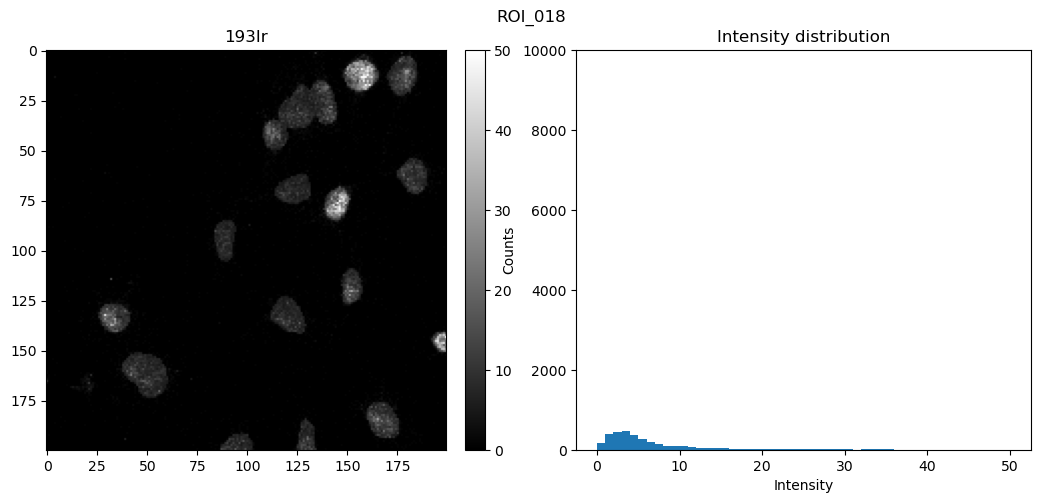

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


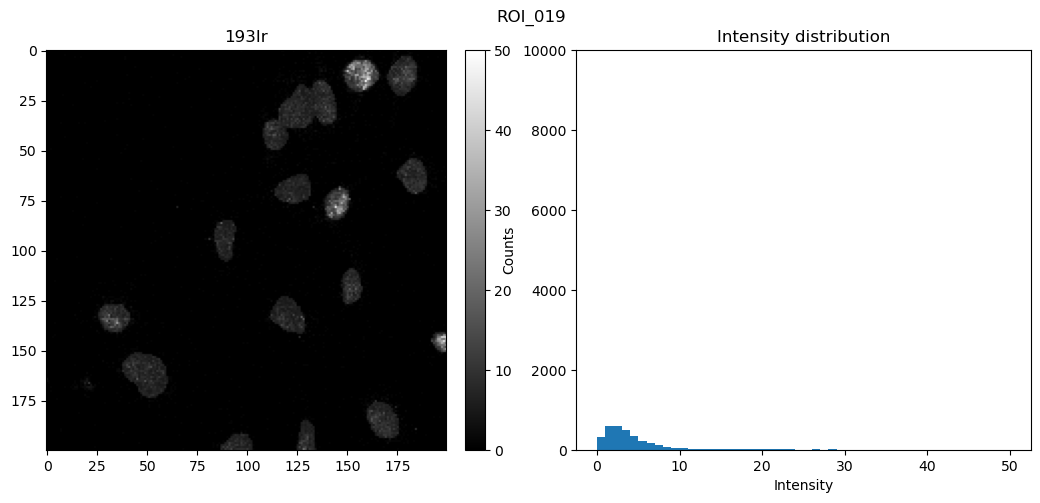

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


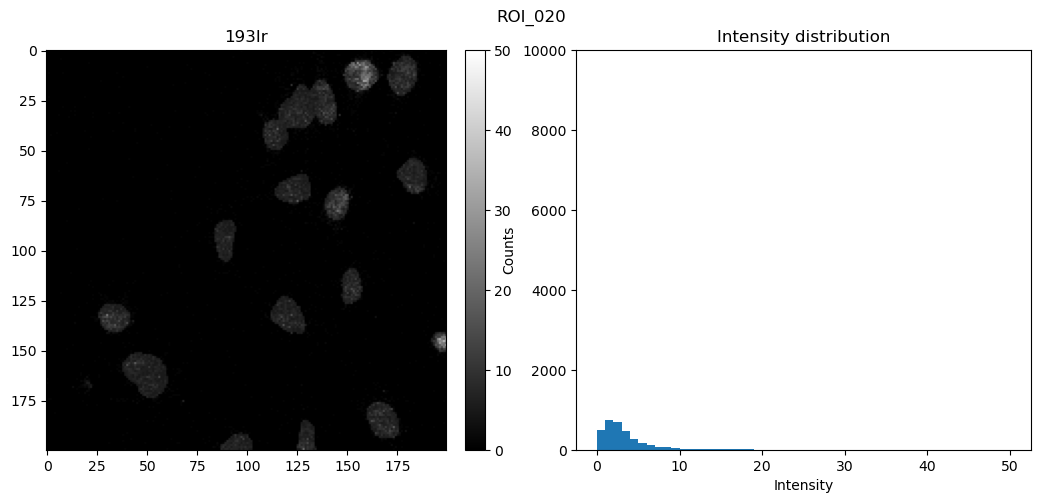

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


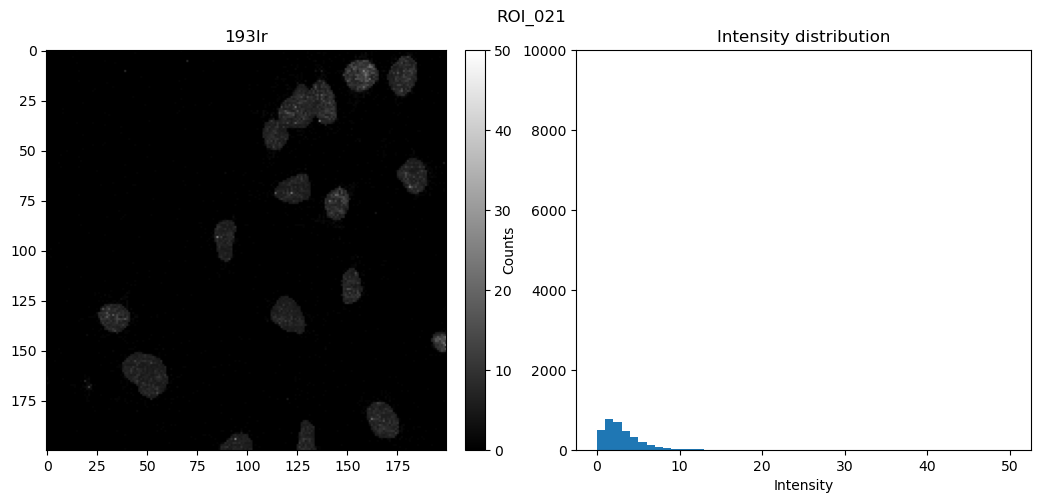

/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


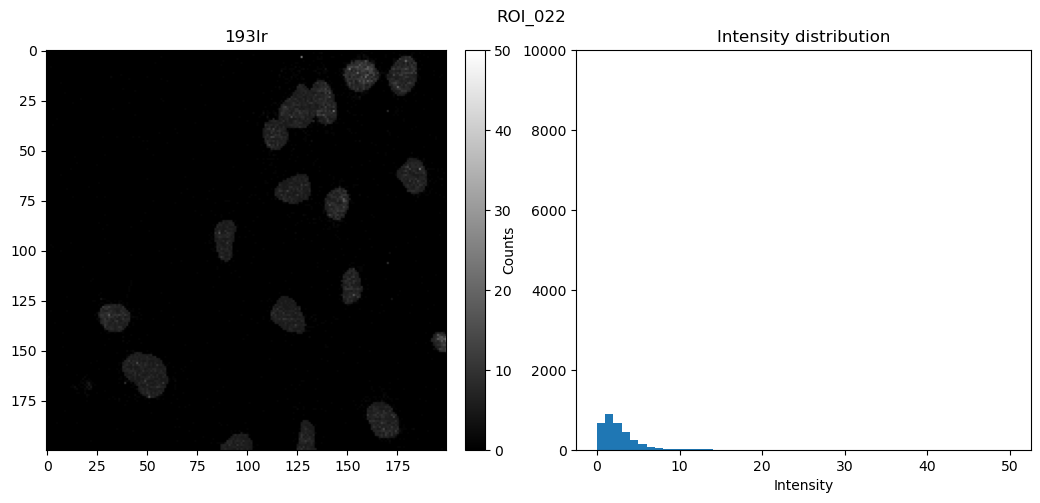

In [170]:
# data frame
imc_193Ir_stats = pd.DataFrame(columns=['shot', 'id', 'mean', 'median', 'std', 'min', 'max'])

# read image id from n to n+10, plot the images
for id in decay_dict[power]:
    shot = df.loc[df['id'] == str(id)]['shot'].values[0]
    imc_dict, channel_labels = read_imc_dict(file_big, id)
    img_imc = imc_dict['imc']
    
    # find the channel label
    chn_idx = channel_labels.index('193Ir_193Ir')
    
    plot_imc_nuc_with_overlays(img_imc, imc_dict, chn_idx, 50, decay_dir, nuc_bmask)
    
    # get statistics of the image with the channel label, only consider the region where nuc_mask is True
    img_imc_193Ir = img_imc[chn_idx, :, :]
    # mask and flatten the image
    img_imc_193Ir_masked = img_imc_193Ir[nuc_bmask].flatten()
    mean = np.mean(img_imc_193Ir_masked)
    median = np.median(img_imc_193Ir_masked)
    std = np.std(img_imc_193Ir_masked)
    min = np.min(img_imc_193Ir_masked)
    max = np.max(img_imc_193Ir_masked)
    
    # add the statistics to the data frame
    imc_193Ir_stats.loc[len(imc_193Ir_stats)] = [shot, id, mean, median, std, min, max]

In [171]:
imc_193Ir_stats

,shot,id,mean,median,std,min,max
0,1.0,13.0,20.752531,20.00,12.698377,0.0,70.00
1,2.0,14.0,29.262270,28.50,12.813539,0.0,80.50
2,3.0,15.0,30.114111,29.25,13.108511,1.0,89.25
3,4.0,16.0,19.276840,17.00,12.078959,0.0,69.50
4,5.0,17.0,10.083896,7.00,9.786453,0.0,67.75
5,6.0,18.0,6.551304,4.00,7.404380,0.0,57.50
6,7.0,19.0,4.264187,3.00,5.151762,0.0,56.25
7,8.0,20.0,2.989187,2.00,3.431279,0.0,32.00
8,9.0,21.0,2.668942,2.00,2.613366,0.0,21.50
9,10.0,22.0,2.093558,2.00,2.127536,0.0,18.75


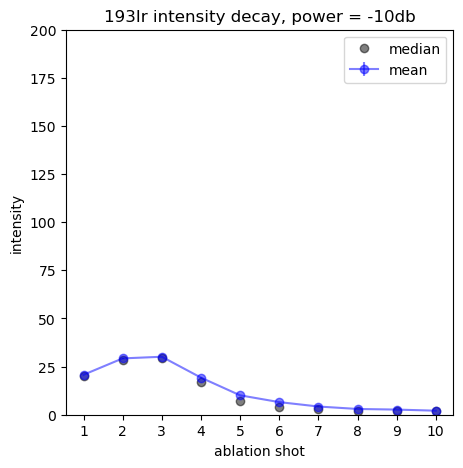

In [172]:
plt.figure(figsize=(5, 5))
plt.errorbar(imc_193Ir_stats['shot'], imc_193Ir_stats['mean'], yerr=imc_193Ir_stats['std']/100, fmt='bo-', alpha = 0.5, label='mean')
# plot the median
plt.plot(imc_193Ir_stats['shot'], imc_193Ir_stats['median'], 'ko', alpha = 0.5, label='median')
plt.legend()

plt.xticks(imc_193Ir_stats['shot'])
plt.xlabel('ablation shot')
plt.ylabel('intensity')
plt.ylim(0, 200)
# set title
plt.title('193Ir intensity decay, power = ' + power)
# save 
plt.savefig(os.path.join(decay_dir, '193Ir_intensity_decay_' + power + '.png'))
plt.show()

### Polynomial fitting

In [173]:
def ablation_decay_poly_fitting(shots, int_mean, degree):
    # shots: list of shot number
    # int_mean: list of mean intensity
    # degree: degree of the polynomial function
    # fit the data with polynomial function
    
    p = np.polyfit(shots, int_mean, degree)
    print('degree:', degree)
    print('fitting parameters:', p)
    
    return p

def ablation_decay_exp_fitting(shots, int_mean):
    # shots: list of shot number
    # int_mean: list of mean intensity
    # fit the data with exponential function
    
    p = np.polyfit(shots, np.log(int_mean), 1)
    print('fitting parameters:', p)
    
    return p

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
5    6.0
6    7.0
7    8.0
8    9.0
Name: shot, dtype: float64
0    20.752531
1    29.262270
2    30.114111
3    19.276840
4    10.083896
5     6.551304
6     4.264187
7     2.989187
8     2.668942
Name: mean, dtype: float64
degree: 8
fitting parameters: [-3.10049638e-04  8.01840285e-03 -4.29826658e-02 -6.32218361e-01
  9.96020782e+00 -5.53660382e+01  1.42391643e+02 -1.59138636e+02
  8.35728478e+01]


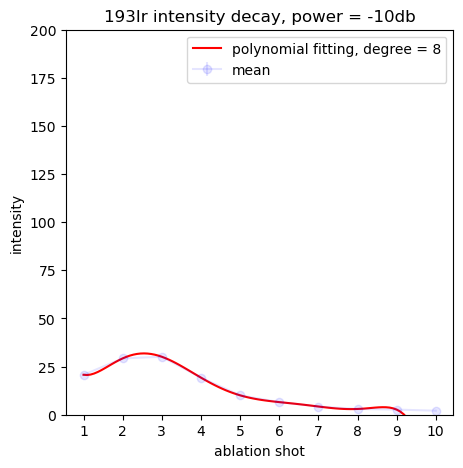

In [176]:
# for harsh ablation, only fit the first few datapoints
ndata = 9
shots = imc_193Ir_stats['shot'][0:ndata]
int_mean = imc_193Ir_stats['mean'][0:ndata]
print(shots)
print(int_mean)
degree = 8

p = ablation_decay_poly_fitting(shots, int_mean, degree)
# p = ablation_decay_exp_fitting(shots, int_mean)

# plot the fitting curve with the data
plt.figure(figsize=(5, 5))
plt.errorbar(imc_193Ir_stats['shot'], imc_193Ir_stats['mean'], yerr=imc_193Ir_stats['std']/100, fmt='bo-', alpha = 0.1, label='mean')
# plot the polynomial fitting curve
x = np.linspace(1, len(imc_193Ir_stats), 100)
y = np.polyval(p, x)
plt.plot(x, y, 'r-', label='polynomial fitting, degree = ' + str(degree))
# plt.plot(x, np.exp(np.polyval(p, x)), 'r-', label='exponential fitting')
plt.legend()
plt.xticks(imc_193Ir_stats['shot'])
plt.xlabel('ablation shot')
plt.ylabel('intensity')
plt.ylim(0, 200)
plt.title('193Ir intensity decay, power = ' + power)
plt.savefig(os.path.join(decay_dir, "193Ir_intensity_decay_" + power + "_fitting.png"))
plt.show()

In [177]:
decay_coeff_dir = os.path.join(data_dir, 'decay_coeff')
if not os.path.exists(decay_coeff_dir):
    os.makedirs(decay_coeff_dir)

In [178]:
# save the degree and the fitting parameters to a csv file
df = pd.DataFrame(columns=['degree', 'coefficients'])
df.loc[len(df)] = [degree, p]
df.to_csv(os.path.join(decay_coeff_dir, '193Ir_intensity_decay_' + power + '_masked_fitting_poly.csv'), index=False)
# df.to_csv(os.path.join(decay_coeff_dir, '193Ir_intensity_decay_' + power + '_masked_fitting_exp.csv'), index=False)

In [ ]:
# read in
df = pd.read_csv(os.path.join(decay_coeff_dir, '193Ir_intensity_decay_' + power + '_masked_fitting_exp.csv'))
degree = df['degree'][0]
p = np.array(df['coefficients'][0].strip('[]').split()).astype(float)
